<a href="https://colab.research.google.com/github/m4chiavelli/analis-cuaca-rmse-vs-mse/blob/main/analis-cuaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Install PySpark
!pip install pyspark

In [54]:
# Import module
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, isnan
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
# Membuka SparkSessioin
spark = SparkSession.builder \
    .appName("Weather Temperature Prediction") \
    .getOrCreate()


In [18]:
!wget https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv

--2024-10-15 17:40:29--  https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5769361 (5.5M) [text/plain]
Saving to: ‘weatherHistory.csv.2’

weatherHistory.csv. 100%[===================>]   5.50M  --.-KB/s    in 0.1s    

2024-10-15 17:40:29 (39.9 MB/s) - ‘weatherHistory.csv.2’ saved [5769361/5769361]



In [19]:
# Memuat Data
data_url = "weatherHistory.csv"
data = pd.read_csv(data_url)

# Konversi DataFrame ke Spark DataFrame
df = spark.createDataFrame(data)


In [48]:
# Pembersihan Data
# Menghitung rata-rata untuk setiap kolom numerik
# (DateTime dan Summary diabaikan karena bukan numerik)
numerical_cols = [c for c in df.columns if c not in ['DateTime', 'Summary', 'Precip Type', 'Daily Summary', 'features']]  # Exclude non-numeric and 'features' columns
mean_values = df.select([mean(col(c)).alias(c) for c in numerical_cols]).first()

# Ganti nilai null, 0, dan NaN dengan rata-rata untuk kolom numerik
for col_name in numerical_cols:
    df = df.na.fill({col_name: mean_values[col_name]})
    df = df.withColumn(col_name, when(col(col_name) == 0, mean_values[col_name]).otherwise(col(col_name)))

# Tambahkan ini untuk menangani NaN yang tersisa setelah pembersihan awal
# Ganti NaN dengan rata-rata kolom
for col_name in numerical_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]  # Calculate mean for each column
    df = df.withColumn(col_name, when(isnan(col(col_name)), mean_value).otherwise(col(col_name)))

# *** Tambahkan langkah untuk menghapus baris dengan NaN di kolom fitur ***
features = ['Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
df = df.na.drop(subset=features)  # Hapus baris dengan NaN di kolom features

Temperature (C)         1.000000
Humidity               -0.639689
Wind Speed (km/h)       0.008690
Pressure (millibars)   -0.307203
Name: Temperature (C), dtype: float64


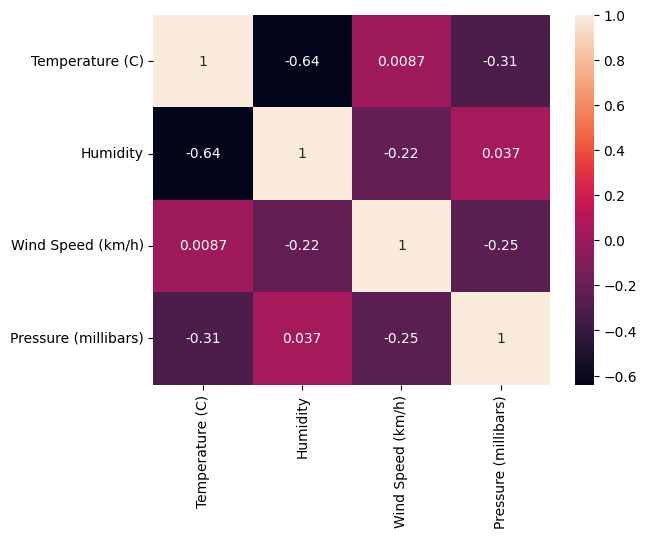

In [49]:
# Perhitungan korelasi
# Hitung nilai korelasi

# Exclude 'DateTime' and other non-numeric columns before calculating correlation
# Ensure 'Temperature (C)' is used as the column name
numeric_df = df.select([c for c in numerical_cols if c in df.columns])
correlation_matrix = numeric_df.toPandas().corr()

# Access the correlation of 'Temperature (C)' instead of 'Temperature'
print(correlation_matrix['Temperature (C)'])

# Visualisasi heatmap
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [56]:
# Pembuatan Vektor Feature
# Variabel untuk model
features = ['Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")  # Change handleInvalid to 'skip'

# Drop the existing 'features' column if it exists
if 'features' in df.columns:
    df = df.drop('features')

# Apply the VectorAssembler to the DataFrame
df = assembler.transform(df)


In [57]:
# Pembagian Training Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [61]:
# Create an Imputer to replace NaN values with the mean of the column
# Include the label column 'Temperature (C)' in the Imputer
imputer = Imputer(
    inputCols=["Humidity", "Wind Speed (km/h)", "Pressure (millibars)", "Temperature (C)"],
    outputCols=["Humidity", "Wind Speed (km/h)", "Pressure (millibars)", "Temperature (C)"]
).setStrategy("mean")

# Apply the Imputer to your data
train_data = imputer.fit(train_data).transform(train_data)

# Drop the existing 'features' column before applying VectorAssembler again
train_data = train_data.drop('features')

# Apply VectorAssembler to create the 'features' column
train_data = VectorAssembler(inputCols=features, outputCol="features").transform(train_data)

# Now try fitting the model again
lr_model_multiple = LinearRegression(featuresCol='features', labelCol='Temperature (C)')
lr_model_multiple.fit(train_data)

LinearRegressionModel: uid=LinearRegression_a27c6cf81b52, numFeatures=3

In [69]:
#Regresi Linier Sederhana (dengan satu fitur, misalnya 'Humidity')

# Drop the existing 'features' column from train_data
train_data_simple = train_data.drop('features')  # Add this line

# Create a new DataFrame with only 'Humidity' and 'Temperature' for simple linear regression
train_data_simple = train_data.select(['Humidity', 'Temperature (C)']) # Add this line

assembler_simple = VectorAssembler(inputCols=['Humidity'], outputCol='features')
train_data_simple = assembler_simple.transform(train_data_simple)  # Transform the new DataFrame

# Similar changes for test_data:
test_data_simple = test_data.select(['Humidity', 'Temperature (C)'])
test_data_simple = assembler_simple.transform(test_data_simple)


lr_model_simple = LinearRegression(featuresCol='features', labelCol='Temperature (C)')  # Use 'Temperature (C)'
lr_model_simple = lr_model_simple.fit(train_data_simple)

In [74]:
# Evaluasi Model
# Prediksi dan evaluasi untuk model Regresi Linier Berganda
# The 'fit' method returns a LinearRegressionModel, which has the 'transform' method
# Assign the result of fit back to lr_model_multiple
lr_model_multiple = lr_model_multiple.fit(train_data)
predictions_multiple = lr_model_multiple.transform(test_data)
evaluator = RegressionEvaluator(labelCol='Temperature (C)', predictionCol='prediction', metricName='rmse') # Change labelCol to 'Temperature (C)'
rmse_multiple = evaluator.evaluate(predictions_multiple)

# Prediksi dan evaluasi untuk model Regresi Linier Sederhana
predictions_simple = lr_model_simple.transform(test_data_simple)
rmse_simple = evaluator.evaluate(predictions_simple)

print(f"RMSE Multiple: {rmse_multiple}, RMSE Simple: {rmse_simple}")

RMSE Multiple: nan, RMSE Simple: nan


ValueError: x and y must be the same size

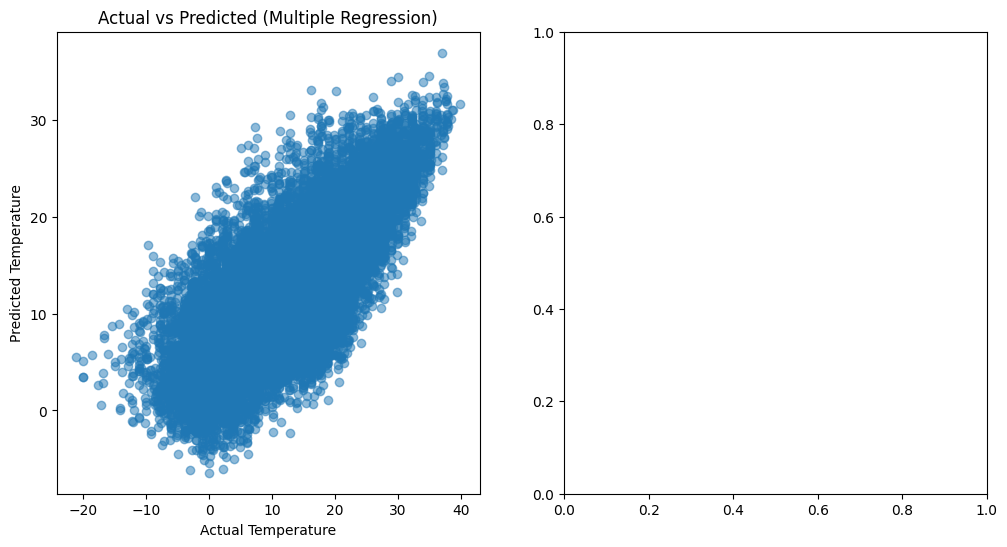

In [76]:
# Visualisasi Hasil
# Visualisasi hasil untuk Regresi Linier Berganda
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Change 'Temperature' to 'Temperature (C)'
plt.scatter(predictions_multiple.select("Temperature (C)").toPandas(), predictions_multiple.select("prediction").toPandas(), alpha=0.5)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted (Multiple Regression)")

# Visualisasi residual
plt.subplot(1, 2, 2)
# Change 'Temperature' to 'Temperature (C)'
plt.scatter(predictions_multiple.select("prediction").toPandas(), predictions_multiple.select("Temperature (C)").toPandas() - predictions_multiple.select("prediction").toPandas())
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Temperature")
plt.ylabel("Residuals")
plt.title("Residuals (Multiple Regression)")

plt.show()